# Prunning research question: categories

## Set-up

In [1]:
try:
    # If we are not on google colab we need to upgrade pandas...
    from google.colab import widgets
    !pip install pandas --upgrade
except ModuleNotFoundError:
    # If we are not on google colab we pass
    pass


from distutils.version import LooseVersion
import pandas as pd
# As we are using features from pandas 0.23, we need to 
# check that the correct version is used.
assert LooseVersion(pd.__version__) > LooseVersion('0.23'), """
If you are on Google Colab and this fails, make sure you "restart runtime"
after running the cell that install the newest version of Pandas
If you are not on Google Colab and this fails, please update your
Pandas version: pip install --upgrade pandas
"""

In [2]:
# The block of code is here to make the notebook Google Colab compatible
try:
    # If we are not on google colab (we assume that you don't have 
    # the google.colab module on your computer...), 
    # the line below will raise an error that will be catch :)
    from google.colab import widgets
    # We clean the content of the directory, so that we can use
    #  git clone directly in it
    !rm -rf *
    !rm -rf .*
    !git clone https://github.com/striantafyllouEPFL/healthy-candies.git .
    # We get the data and initialize everything
    !python ./init_project.py
except ModuleNotFoundError:
    pass

In [3]:
import pandas as pd
import numpy as np

# Project specific module/functions
from healthy_candies.load import load_data
from healthy_candies.path import OFF_CAT_CSV, WIKIDATA_CAT_TREE_CSV
from healthy_candies.utils import plot_settings, log_bins


import seaborn as sns
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
# further plot settings
sns.set()  # Use default seaborn styling for all plots
sns.set_context('notebook')
plt.rcParams['figure.dpi'] = 100

*One of the first objective we had internally in the team was to be able to generalize our approach to as many products categories as possible. The aim of this notebook is to explain why we dropped this idea.*

In [5]:
COL_NUTRI_CAT = 'nutrition_grade_fr'
COL_NUTRI_FLOAT = 'nutrition-score-fr_100g'
COL_MAIN_CAT = 'main_category'
COL_PRODUCT_NAME = 'product_name'

## Exploring the categories

Of all the products that are contained in the dataset, we have only $\approx 140\,000$ products for which we have information on the associated nutriscore.

In [6]:
df = load_data(usecols=[COL_NUTRI_FLOAT,
                        COL_NUTRI_CAT,
                        COL_MAIN_CAT,
                        COL_PRODUCT_NAME],
               limit_have_nutri_score=True)
df.shape

(141605, 4)

In the Open Food Facts database, all products are associated with one or more categories. Our first objective was therefore to see how many categories are present among the data. We can do that by looking at the `main_category` column of the dataset. What we first found is that the number of categories is huge with $\approx 4\,742$ different categories present in the data.

In [7]:
categories = df[COL_MAIN_CAT]
cat_counts = categories.value_counts()
cat_counts.shape

(4742,)

Also, the number of products in each category follows a distribution close to a power law: many categories have very few products whereas few categories are associated with many categories.

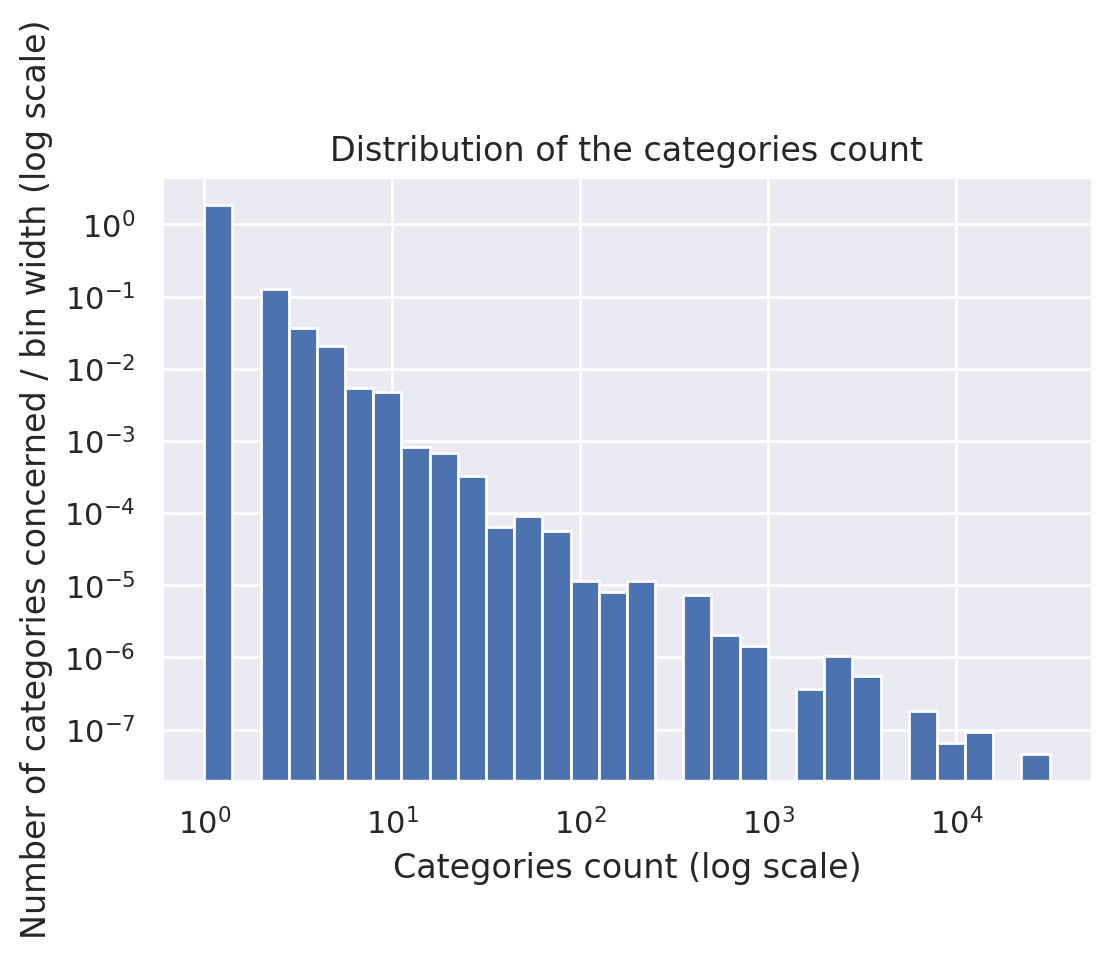

In [8]:
bins = log_bins(cat_counts, 30)
cat_counts.hist(bins=bins, density=True)

plot_settings({
    'title': 'Distribution of the categories count',
    'xlabel': 'Categories count (log scale)',
    'ylabel': 'Number of categories concerned / bin width (log scale)',
    'xscale': 'log',
    'yscale': 'log'})

When we look at the categories that are the most frequent, we find one called `en:plant-based-foods-and-beverages`.

In [9]:
cat_counts.head(10)

en:plant-based-foods-and-beverages    31319
en:sugary-snacks                      22854
en:beverages                          14398
en:dairies                            14260
en:meats                               8265
en:meals                               7417
en:groceries                           6885
en:frozen-foods                        2992
en:spreads                             2914
en:desserts                            2836
Name: main_category, dtype: int64

If we look at a sample from of the products from that category, we can find very diverse things that are not comparable (olive oil, jam, butter, nuggets, etc.). This category must be the default one in the app that helps to collect information on the products.

In [10]:
df[df[COL_MAIN_CAT] == 'en:plant-based-foods-and-beverages'][COL_PRODUCT_NAME] \
    .sample(10, random_state=10)

332961                Confiture de Framboise
403604                                Cassis
641444       Bio olio extra vergine di oliva
382372                      Perles blanches 
327897                  Confiture d'abricots
653808                     Dátiles con hueso
633561                                Victor
377875                          Oméga 3 doux
423457                   Nuggets végétariens
599249    Aceite de semilla de uva Grapecare
Name: product_name, dtype: object

**As a result we won't be able to assume that the content of all categories is homogenous.**

## Grouping the categories

Since there are many categories inside the data, we were still interested into grouping those categories automatically, to have relevant bigger categories.

To do this we used two other datasets:
* The first one is the list of categories [provided by  Open Food Facts](https://world.openfoodfacts.org/categories.json) that contains also for some categories a matching *Wikidata* entry,
* The second one is dataset build from a [hierarchy of entries](https://tools.wmflabs.org/wikidata-todo/tree.html?q=2095&rp=279) related to food on *Wikidata*.

Using the hierarchy, we tried to group categories of open food facts. We built the necessary script to perform this task, but the results are not successful. Let's explore.

The head of the first (custom) dataset is shown below. For each category on Open Food Facts, the matching wiki data id is given if it exists. 

In [11]:
# Load the 2 new datasets (custom formatted)
df_off_cat = pd.read_csv(OFF_CAT_CSV)
df_off_cat = df_off_cat.fillna('')
df_off_cat.head()

,catIdOff,wikidataId
0,en:plant-based-foods-and-beverages,
1,en:plant-based-foods,
2,en:beverages,Q40050
3,en:sugary-snacks,
4,en:dairies,Q185217


We can see that we have $998$ products with a matching wikidataId, which is pretty good ! 

In [12]:
df_off_cat.wikidataId.value_counts().shape

(998,)

The head of the second (custom) dataset is shown below. For each `wikidataId` we have the matching category parent according to the wikidata. In column `0` we have the closest parent to the food category, in column `1` we have the closest parent separated by distance 1 from the food category, etc.

In [13]:
df_h = pd.read_csv(WIKIDATA_CAT_TREE_CSV)
df_h.head(5)

,0,1,2,3,4,5,6,7,8,9,10,wikidataId,wikidataName
0,Q1269,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Q1093768,Bar-le-duc jelly
1,Q1269,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Q55181446,Amarene brusche di Modena
2,Q1269,Q94835,Q94835,Q94835,Q94835,Q94835,Q94835,Q94835,Q94835,Q94835,Q94835,Q94835,coconut jam
3,Q1269,Q555084,Q555084,Q555084,Q555084,Q555084,Q555084,Q555084,Q555084,Q555084,Q555084,Q555084,quince cheese
4,Q1269,Q920658,Q256622,Q256622,Q256622,Q256622,Q256622,Q256622,Q256622,Q256622,Q256622,Q256622,powidl


Doing the merge between the main dataset and the one with all the categories is performed with a negligible loss of data.

In [14]:
df_with_wikiId = df.merge(
    df_off_cat, left_on=COL_MAIN_CAT, right_on='catIdOff')
df_with_wikiId.shape

(141566, 6)

However, the mapping from a product to wikidataId concerns only $\approx 42 \,000$ products.

In [15]:
sum(df_with_wikiId['wikidataId'] != '')

41820

And we are left with only $23$ different categories.

In [16]:
tmp = df_with_wikiId['wikidataId'].value_counts()
tmp.shape

(23,)

In [17]:
tmp

             99746
Q40050       14398
Q185217      14260
Q3391775      7417
Q18396746     2413
Q28803         866
Q4368298       731
Q645858        419
Q11175039      396
Q1142483       246
Q6648982       206
Q1621080       156
Q189567         81
Q106252         70
Q6584340        69
Q41354          33
Q5876127        25
Q1255306        17
Q1626970         8
Q13360264        5
Q300472          2
Q797971          1
Q1709220         1
Name: wikidataId, dtype: int64

Now, we continue by merging the data with the second dataset also.

In [18]:
df_final = df_with_wikiId.merge(df_h, on='wikidataId')

Again we lose some products and we are left with $\approx 34\,000$ products.

In [19]:
df_final.shape

(33589, 18)

At the end, we are left with $18$ categories from Open Food Facts (shown below).

In [20]:
df_final[COL_MAIN_CAT].value_counts()

en:beverages                     14398
en:dairies                       14260
en:canned-foods                   2413
en:sandwiches                      866
en:dietary-supplements             419
en:terrine                         396
en:pies                            246
en:pet-food                        206
en:olives                          156
en:marzipan                         70
en:syrups                           69
en:vinegars                         33
en:christmas-foods-and-drinks       25
en:dragees                          17
en:milk-substitute                   8
en:two-crust-pies                    5
en:baby-foods                        1
fr:blondies                          1
Name: main_category, dtype: int64

Using the data from the second dataset, we can match those $18$ categories to only $11$ categories.

In [21]:
df_final['0'].value_counts().shape

(11,)

**At the end, all this work is not very successful.**


As a result, we could focus on a curated list of categories for our project if we want to focus on the categorical aspects of products. Doing so would enable to check a bit more what's inside a category for example.